<a href="https://colab.research.google.com/github/SachinRajput-SSR/Smart-Grid-Energy-Optimization/blob/main/notebooks/02_model_training_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# ----- Week 1: Data Loading and Preparation -----

In [3]:
# 1. Load Dataset from GitHub folder (data/raw)
file_path = 'https://raw.githubusercontent.com/SachinRajput-SSR/Smart-Grid-Energy-Optimization/c213e8e7cd25bd5015b9760406144f04fb47b81f/data/raw/smart_grid_stability_augmented.csv'
data = pd.read_csv(file_path)

In [4]:
# Basic exploration
print("Dataset Overview:")
print(data.info())
print(data['stabf'].value_counts())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 6.4+ MB
None
stabf
unstable    38280
stable      21720
Name: count, dtype: int64


In [5]:
# Data cleaning
data = data.drop_duplicates()
for col in data.select_dtypes(include=[np.number]).columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

In [6]:
# Define X and y
X = data.drop(columns=['stabf'])
y = data['stabf'].map({'stable': 1, 'unstable': 0})

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (48000, 13), Test data shape: (12000, 13)


In [8]:
# ----- Week 2: Model Training and Initial Evaluation -----

In [9]:
# Define models and hyperparameters
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'learning_rate': [0.1, 0.01],
        'max_depth': [3, 5],
        'n_estimators': [100, 200]
    }
}

best_models = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {name}: {grid_search.best_params_}")

    y_pred = grid_search.predict(X_test)
    y_proba = grid_search.predict_proba(X_test)[:, 1]

    print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred)}")
    print(f"ROC-AUC Score for {name}: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Confusion Matrix for {name}:\n{confusion_matrix(y_test, y_pred)}")

    best_models[name] = grid_search.best_estimator_


Training Random Forest model...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7656
           1       1.00      1.00      1.00      4344

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

ROC-AUC Score for Random Forest: 1.0000
Confusion Matrix for Random Forest:
[[7656    0]
 [   0 4344]]

Training XGBoost model...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7656
           1       1.00      1.00      1.00      4344

    accuracy                           1.00     12000
   macro avg       1.00    

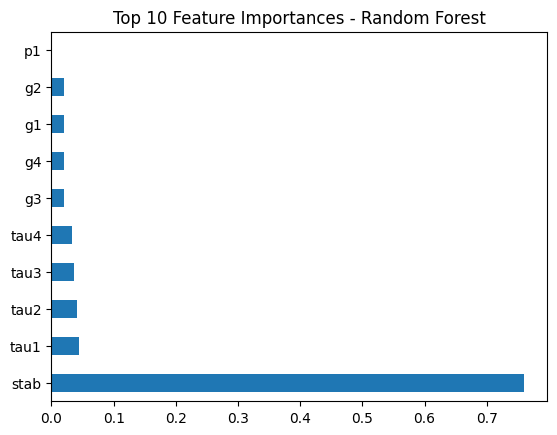

In [10]:
# Feature importance from Random Forest
rf = best_models['Random Forest']
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances - Random Forest')
plt.show()